In [4]:
import pandas as pd
from datetime import datetime
import os

def merge_iqm_lpips(mri_type):
    groups = ["g1", "g2", "g3", "g4", "g5"]

    for g in groups:
        iqm_file = f"{mri_type}/{mri_type}_{g}_iqm.csv"
        lpips_file = f"lpips_csv/{mri_type}/{mri_type}_{g}_lpips.csv"

        iqm_df = pd.read_csv(iqm_file)
        lpips_df = pd.read_csv(lpips_file)

        lpips_df["Subject ID"] = lpips_df["Filename"].str.replace(".npy", "", regex=True)
        lpips_df["Slice Index"] = lpips_df["Slice"] - 1
        lpips_df = lpips_df.drop(columns=["Filename", "Slice"])

        merged_df = iqm_df.merge(lpips_df, on=["Subject ID", "Slice Index"], how="left")
        merged_df = merged_df.rename(columns={"LPIPS_Score": "LPIPS"})
        merged_df = merged_df[merged_df["Slice Index"] <= 9]

        timestamp = datetime.now().strftime("%Y%m%d")
        dir_path = f"iqm_csv_{timestamp}/{mri_type}"
        os.makedirs(dir_path, exist_ok=True)
        merged_df.to_csv(f"iqm_csv_{timestamp}/{mri_type}/{mri_type}_{g}_iqm.csv", index=False)

    print(f"{mri_type} MRI 유형에 대한 모든 그룹(g1~g5) 데이터 병합 완료!")

mri_types = ["flair", "t1", "t1post", "t2"]
for mri in mri_types:
    merge_iqm_lpips(mri)

flair MRI 유형에 대한 모든 그룹(g1~g5) 데이터 병합 완료!
t1 MRI 유형에 대한 모든 그룹(g1~g5) 데이터 병합 완료!
t1post MRI 유형에 대한 모든 그룹(g1~g5) 데이터 병합 완료!
t2 MRI 유형에 대한 모든 그룹(g1~g5) 데이터 병합 완료!


In [5]:
import pandas as pd
import ast
import re

def parse_tensor_string(tensor_string):
    try:
        return ast.literal_eval(tensor_string.replace("tensor(", "").replace(")", ""))
    except:
        return tensor_string

def process_iqm_data(category):
    # List of files for each category
    files = [
        f'{category}_g1_iqm.csv',
        f'{category}_g2_iqm.csv',
        f'{category}_g3_iqm.csv',
        f'{category}_g4_iqm.csv',
        f'{category}_g5_iqm.csv'
    ]
    
    all_data = []
    for file in files:
        df = pd.read_csv(f'iqm_csv_20250215/{category}/{file}')
        motion_level = int(re.search(r'g(\d+)', file).group(1))
        df['Motion_Level'] = motion_level
        all_data.append(df)
    
    if not all_data:
        return  # If no data was appended, skip processing
    
    combined_df = pd.concat(all_data, ignore_index=True)
    
    for column in combined_df.columns:
        combined_df[column] = combined_df[column].apply(parse_tensor_string)
    
    combined_df.to_csv(f'iqm_csv_20250215/{category}/combined_{category}_iqm.csv', index=False)

# Process each category
for category in ['t1', 't2', 't1post', 'flair']:
    process_iqm_data(category)

In [6]:
files = {
    "t1": "iqm_csv_20250215/t1/combined_t1_iqm.csv",
    "t2": "iqm_csv_20250215/t2/combined_t2_iqm.csv",
    "t1post": "iqm_csv_20250215/t1post/combined_t1post_iqm.csv",
    "flair": "iqm_csv_20250215/flair/combined_flair_iqm.csv"
}

dataframes = []

for sequence_name, file_path in files.items():
    df = pd.read_csv(file_path)
    df["sequence"] = sequence_name
    dataframes.append(df)

combined_df = pd.concat(dataframes, ignore_index=True)
combined_df.to_csv("fr-iqm_20250215.csv", index=False)

combined_df

,Subject ID,Slice Index,Haarpsi,VSI,VIF,NQM,LPIPS,Motion_Level,sequence
0,brain_AXT1_201_6002836,0,0.991571,0.9983,0.8545,39.357306,0.031779,1,t1
1,brain_AXT1_201_6002836,1,0.957855,0.9962,0.7427,32.222995,0.063850,1,t1
2,brain_AXT1_201_6002836,2,0.957235,0.9956,0.7681,33.599261,0.062784,1,t1
3,brain_AXT1_201_6002836,3,0.995300,0.9992,0.9139,39.143707,0.016763,1,t1
4,brain_AXT1_201_6002836,4,0.982608,0.9977,0.8573,37.302301,0.032506,1,t1
...,...,...,...,...,...,...,...,...,...
22895,brain_AXFLAIR_200_6002435,5,0.899466,0.9855,0.5219,32.686629,0.122858,5,flair
22896,brain_AXFLAIR_200_6002435,6,0.854933,0.9776,0.4370,27.741778,0.163559,5,flair
22897,brain_AXFLAIR_200_6002435,7,0.918877,0.9836,0.5042,33.632997,0.136577,5,flair
22898,brain_AXFLAIR_200_6002435,8,0.937715,0.9874,0.5239,31.091476,0.119854,5,flair


In [7]:
import numpy as np

def bin_iqm(df, column_names):
    df_copy = df.copy()
    
    for column_name in column_names:
        data = df_copy[column_name]
        
        counts, bin_edges = np.histogram(data, bins=100, range=(data.min(), data.max()))
        bin_indices = np.digitize(data, bins=bin_edges[:-1], right=False) - 1

        bin_indices = np.clip(bin_indices, 0, 99)

        df_copy[column_name] = bin_indices
    
    return df_copy

In [ ]:
columns = ['Haarpsi', 'VSI', 'VIF', 'NQM', 'LPIPS']
# filtered_df = combined_df[(combined_df["Slice Index"] < 10)]
binned_df = bin_iqm(combined_df, columns)
binned_df

,Subject ID,Slice Index,Haarpsi,VSI,VIF,NQM,LPIPS,Motion_Level,sequence
0,brain_AXT1_201_6002836,0,98,98,85,68,5,1,t1
1,brain_AXT1_201_6002836,1,94,97,74,57,11,1,t1
2,brain_AXT1_201_6002836,2,94,97,76,59,10,1,t1
3,brain_AXT1_201_6002836,3,99,99,91,67,2,1,t1
4,brain_AXT1_201_6002836,4,97,98,85,65,5,1,t1
...,...,...,...,...,...,...,...,...,...
22895,brain_AXFLAIR_200_6002435,5,87,90,51,58,21,5,flair
22896,brain_AXFLAIR_200_6002435,6,82,85,43,50,28,5,flair
22897,brain_AXFLAIR_200_6002435,7,90,89,50,59,23,5,flair
22898,brain_AXFLAIR_200_6002435,8,92,92,52,55,20,5,flair


In [9]:
t1 = binned_df[binned_df['sequence'] == 't1']
t2 = binned_df[binned_df['sequence'] == 't2']
t1post = binned_df[binned_df['sequence'] == 't1post']
flair = binned_df[binned_df['sequence'] == 'flair']

In [10]:
max_min_values = t1.groupby('Motion_Level')[['Haarpsi', 'VSI', 'VIF', 'NQM', 'LPIPS']].agg(['min', 'max'])

max_min_values

Haarpsi     VSI     VIF     NQM     LPIPS    
                 min max min max min max min max   min max
Motion_Level                                              
1                 90  99  95  99  65  99  44  99     0  26
2                 78  99  84  99  46  93  37  79     3  43
3                 74  99  82  99  41  88  35  75     5  46
4                 72  99  80  99  38  82  34  71    10  48
5                 70  98  79  98  30  74  29  70    12  48

/var/folders/4p/jwpzj_n95c12lkmr54khzxfw0000gn/T/ipykernel_61707/521152379.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Motion_Level', y=column, data=t1, palette='bright')
/var/folders/4p/jwpzj_n95c12lkmr54khzxfw0000gn/T/ipykernel_61707/521152379.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Motion_Level', y=column, data=t1, palette='bright')
/var/folders/4p/jwpzj_n95c12lkmr54khzxfw0000gn/T/ipykernel_61707/521152379.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Motion_Level', y=column, data=t1, palette='bright')
/

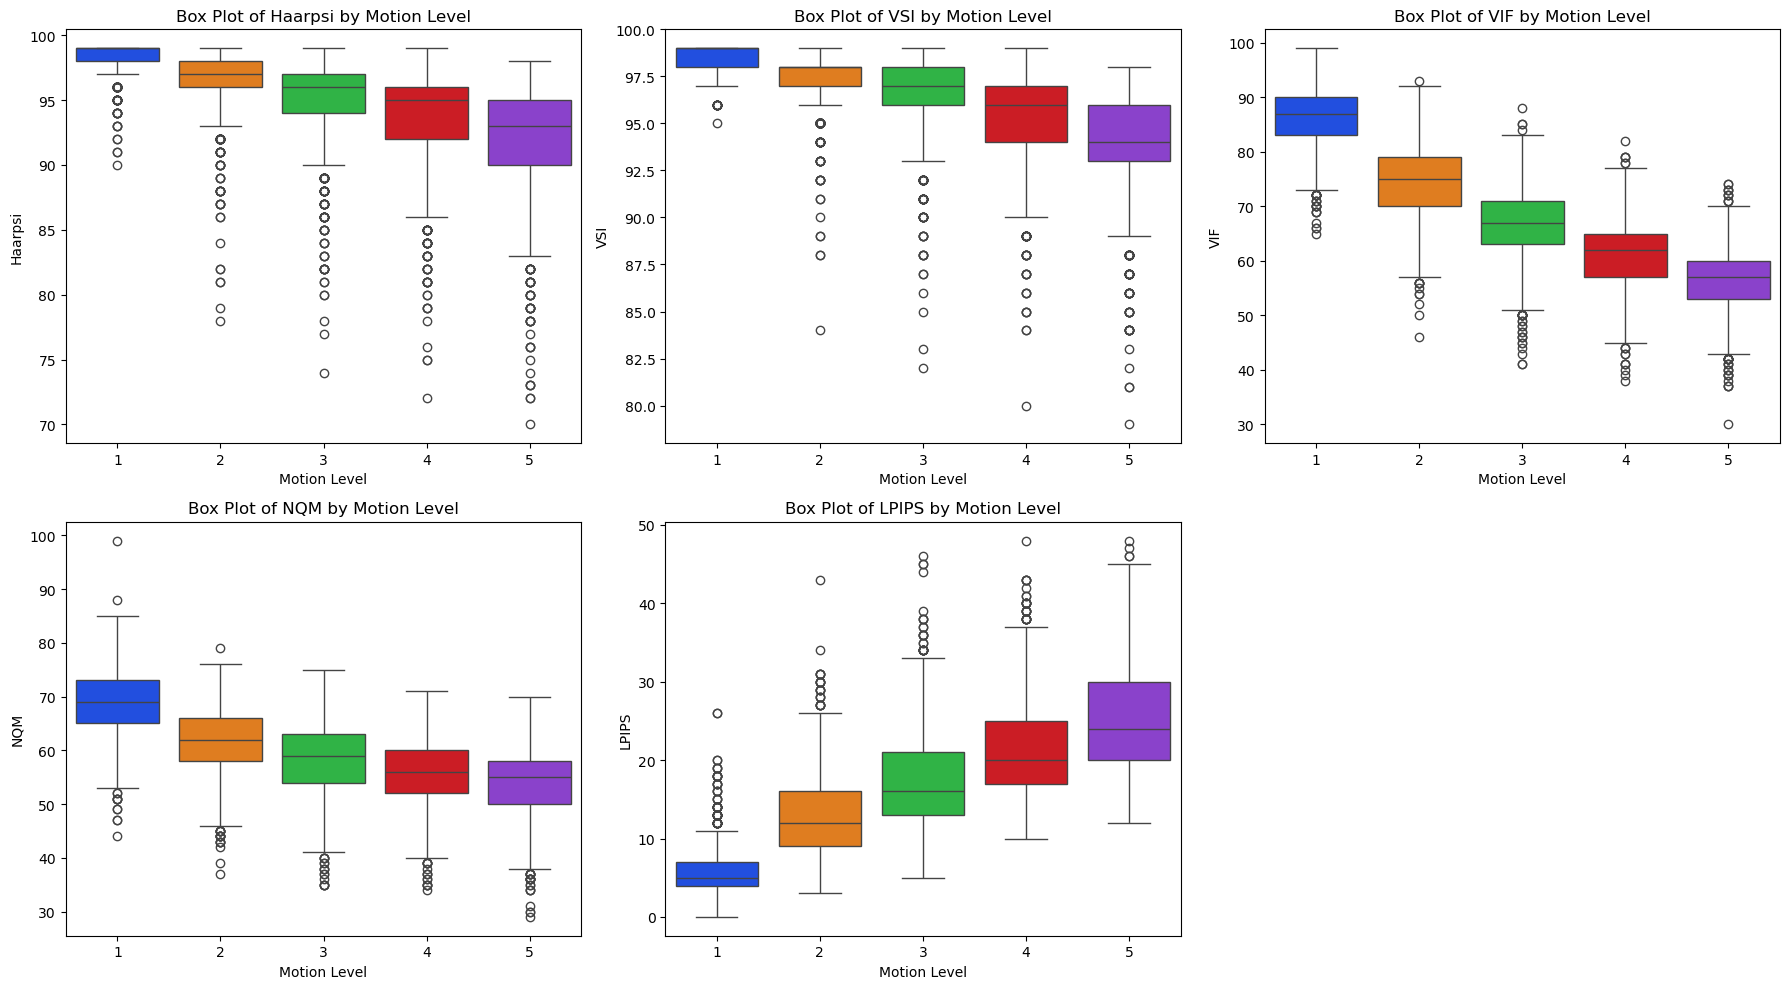

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18, 10))

for i, column in enumerate(['Haarpsi', 'VSI', 'VIF', 'NQM', 'LPIPS'], 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Motion_Level', y=column, data=t1, palette='bright')
    plt.title(f'Box Plot of {column} by Motion Level')
    plt.xlabel('Motion Level')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

In [14]:
max_min_values = t1post.groupby('Motion_Level')[['Haarpsi', 'VSI', 'VIF', 'NQM', 'LPIPS']].agg(['min', 'max'])

max_min_values

Haarpsi     VSI     VIF     NQM     LPIPS    
                 min max min max min max min max   min max
Motion_Level                                              
1                 27  99  73  99  21  98  18  88     1  68
2                 21  99  62  99  18  92  13  80     4  78
3                 13  99  54  99  12  91  13  75     4  82
4                  2  99  22  99   3  83   9  74    10  94
5                  1  99   0  98   0  79   5  71    11  96

/var/folders/4p/jwpzj_n95c12lkmr54khzxfw0000gn/T/ipykernel_61707/1349753359.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Motion_Level', y=column, data=t1post, palette='bright')
/var/folders/4p/jwpzj_n95c12lkmr54khzxfw0000gn/T/ipykernel_61707/1349753359.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Motion_Level', y=column, data=t1post, palette='bright')
/var/folders/4p/jwpzj_n95c12lkmr54khzxfw0000gn/T/ipykernel_61707/1349753359.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Motion_Level', y=column, data=t1post, pale

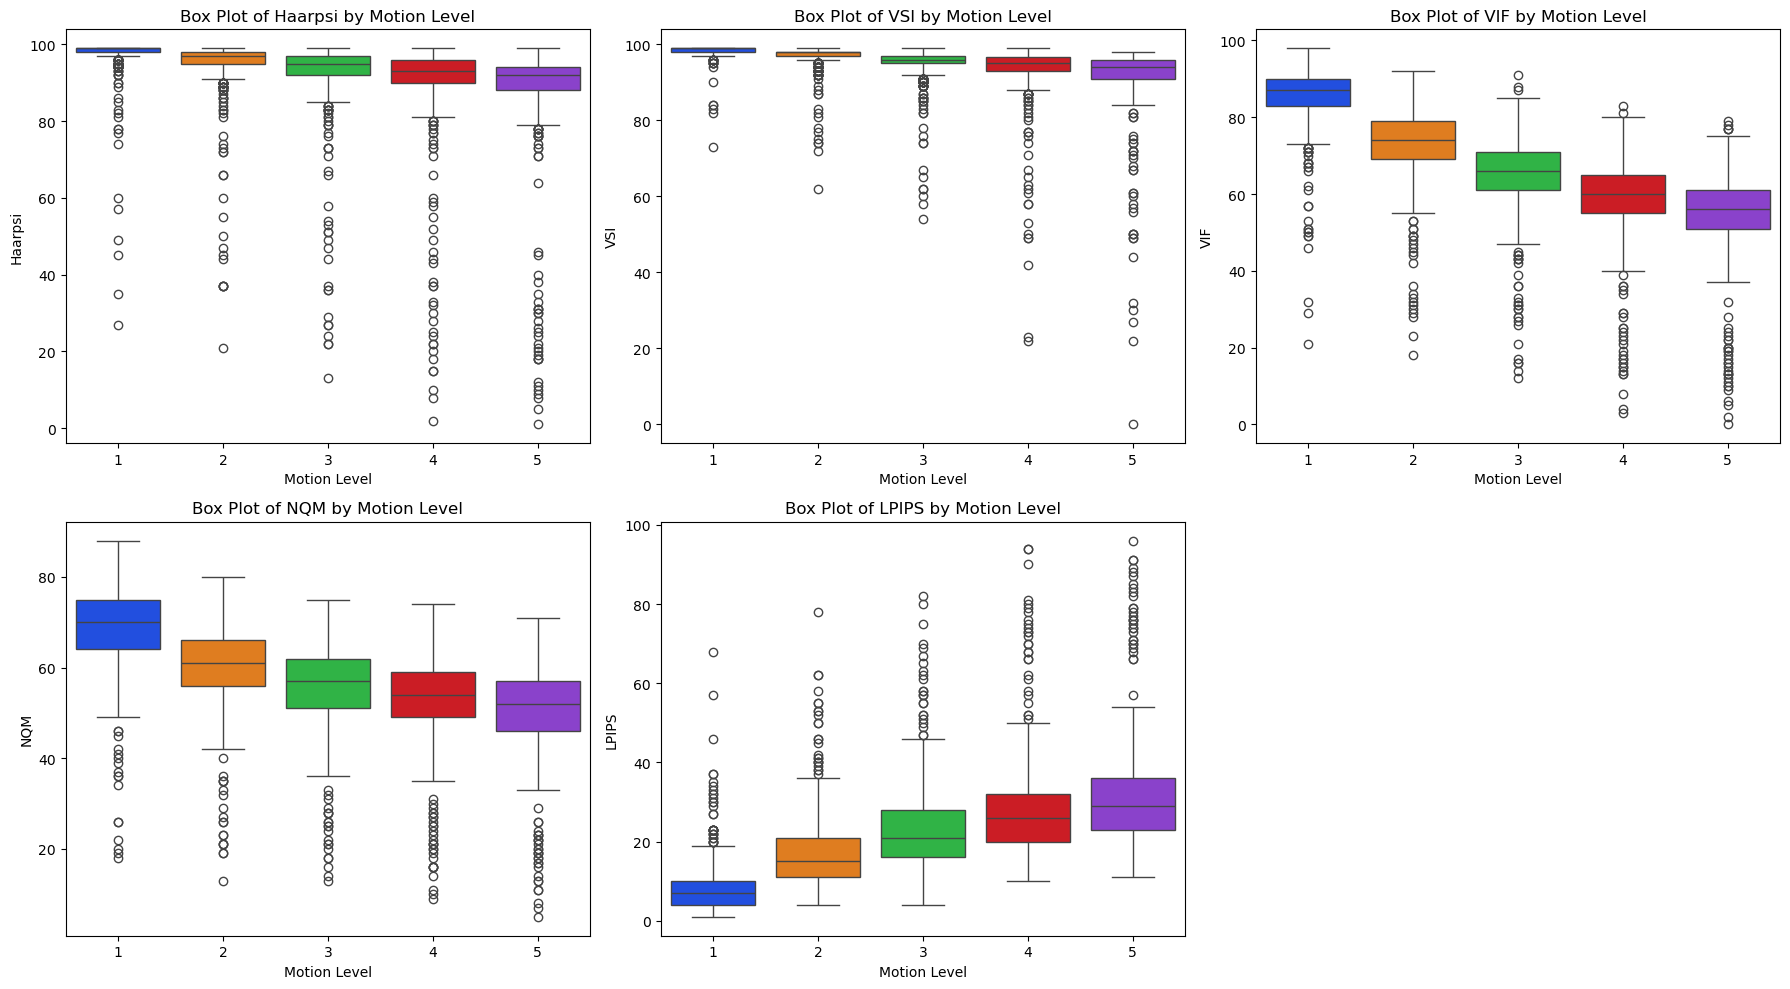

In [31]:
plt.figure(figsize=(18, 10))

for i, column in enumerate(['Haarpsi', 'VSI', 'VIF', 'NQM', 'LPIPS'], 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Motion_Level', y=column, data=t1post, palette='bright')
    plt.title(f'Box Plot of {column} by Motion Level')
    plt.xlabel('Motion Level')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

In [16]:
max_min_values = flair.groupby('Motion_Level')[['Haarpsi', 'VSI', 'VIF', 'NQM', 'LPIPS']].agg(['min', 'max'])

max_min_values

Haarpsi     VSI     VIF     NQM     LPIPS    
                 min max min max min max min max   min max
Motion_Level                                              
1                 23  99  54  99   3  99   5  96     0  78
2                 19  99  49  99  10  92  10  75     2  77
3                  8  99  36  99   1  91   4  70     5  92
4                  7  98  23  99   0  81   1  66     8  93
5                  0  99  13  99   0  79   0  63     9  97

/var/folders/4p/jwpzj_n95c12lkmr54khzxfw0000gn/T/ipykernel_61707/1065555616.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Motion_Level', y=column, data=flair, palette='bright')
/var/folders/4p/jwpzj_n95c12lkmr54khzxfw0000gn/T/ipykernel_61707/1065555616.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Motion_Level', y=column, data=flair, palette='bright')
/var/folders/4p/jwpzj_n95c12lkmr54khzxfw0000gn/T/ipykernel_61707/1065555616.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Motion_Level', y=column, data=flair, palette

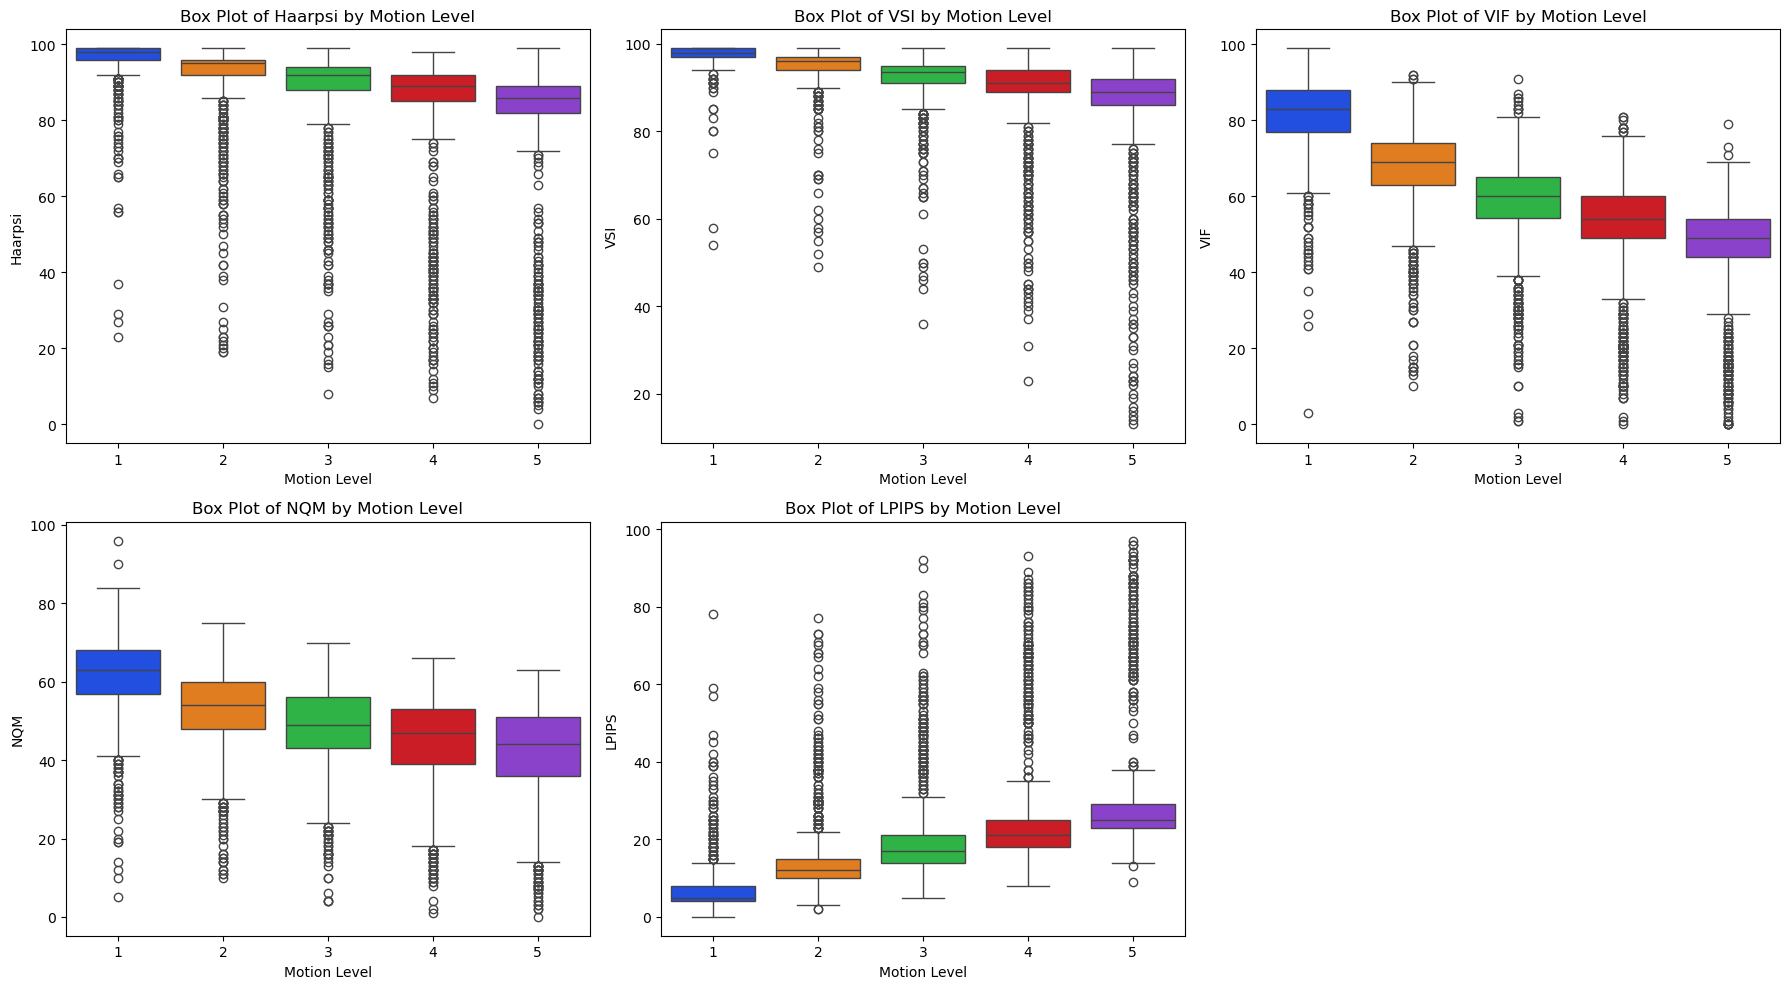

In [18]:
plt.figure(figsize=(18, 10))

for i, column in enumerate(['Haarpsi', 'VSI', 'VIF', 'NQM', 'LPIPS'], 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Motion_Level', y=column, data=flair, palette='bright')
    plt.title(f'Box Plot of {column} by Motion Level')
    plt.xlabel('Motion Level')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

In [19]:
max_min_values = t2.groupby('Motion_Level')[['Haarpsi', 'VSI', 'VIF', 'NQM', 'LPIPS']].agg(['min', 'max'])

max_min_values

Haarpsi     VSI     VIF     NQM     LPIPS    
                 min max min max min max min max   min max
Motion_Level                                              
1                 12  99  40  99   8  98   9  86     0  77
2                  9  99  26  99   5  89   6  78     3  83
3                  7  98  12  99   2  78   6  71     8  90
4                  3  98   4  99   0  76   6  70    10  92
5                  5  97   5  99   1  71   4  70    14  99

/var/folders/4p/jwpzj_n95c12lkmr54khzxfw0000gn/T/ipykernel_61707/2503205144.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Motion_Level', y=column, data=t2, palette='bright')
/var/folders/4p/jwpzj_n95c12lkmr54khzxfw0000gn/T/ipykernel_61707/2503205144.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Motion_Level', y=column, data=t2, palette='bright')
/var/folders/4p/jwpzj_n95c12lkmr54khzxfw0000gn/T/ipykernel_61707/2503205144.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Motion_Level', y=column, data=t2, palette='bright'

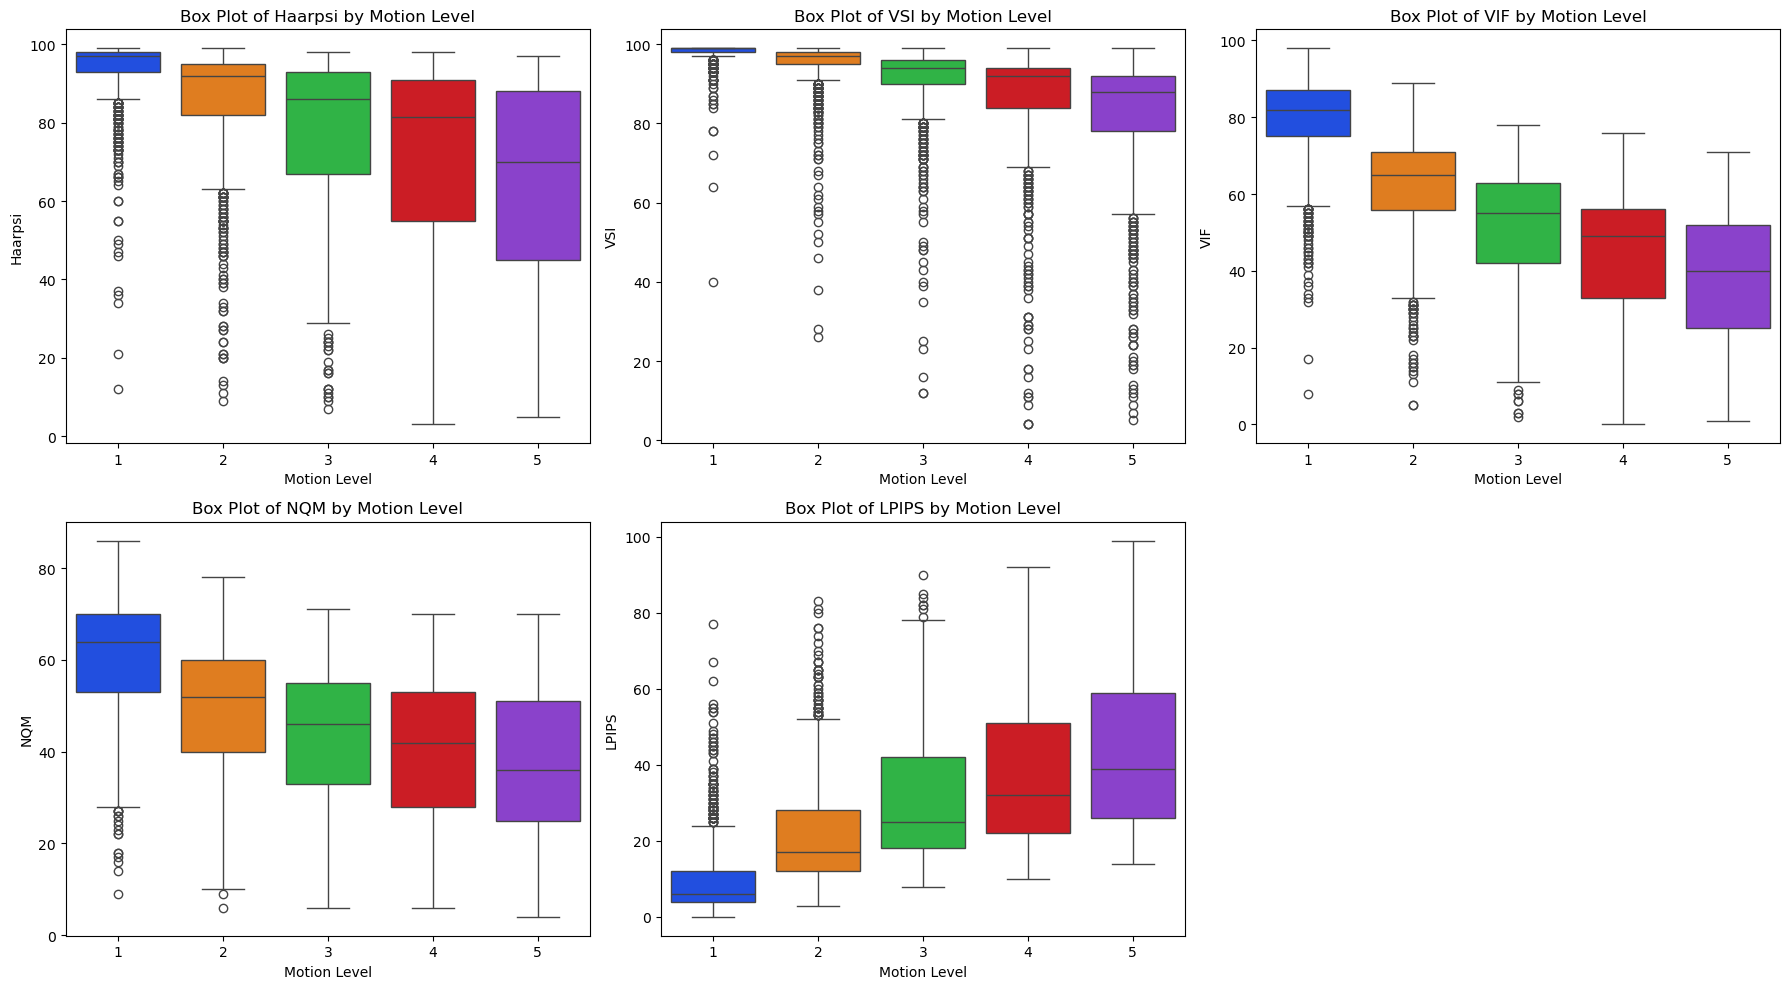

In [20]:
plt.figure(figsize=(18, 10))

for i, column in enumerate(['Haarpsi', 'VSI', 'VIF', 'NQM', 'LPIPS'], 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Motion_Level', y=column, data=t2, palette='bright')
    plt.title(f'Box Plot of {column} by Motion Level')
    plt.xlabel('Motion Level')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

In [21]:
t1_df = combined_df[combined_df['sequence'] == 't1']
t2_df = combined_df[combined_df['sequence'] == 't2']
t1post_df = combined_df[combined_df['sequence'] == 't1post']
flair_df = combined_df[combined_df['sequence'] == 'flair']

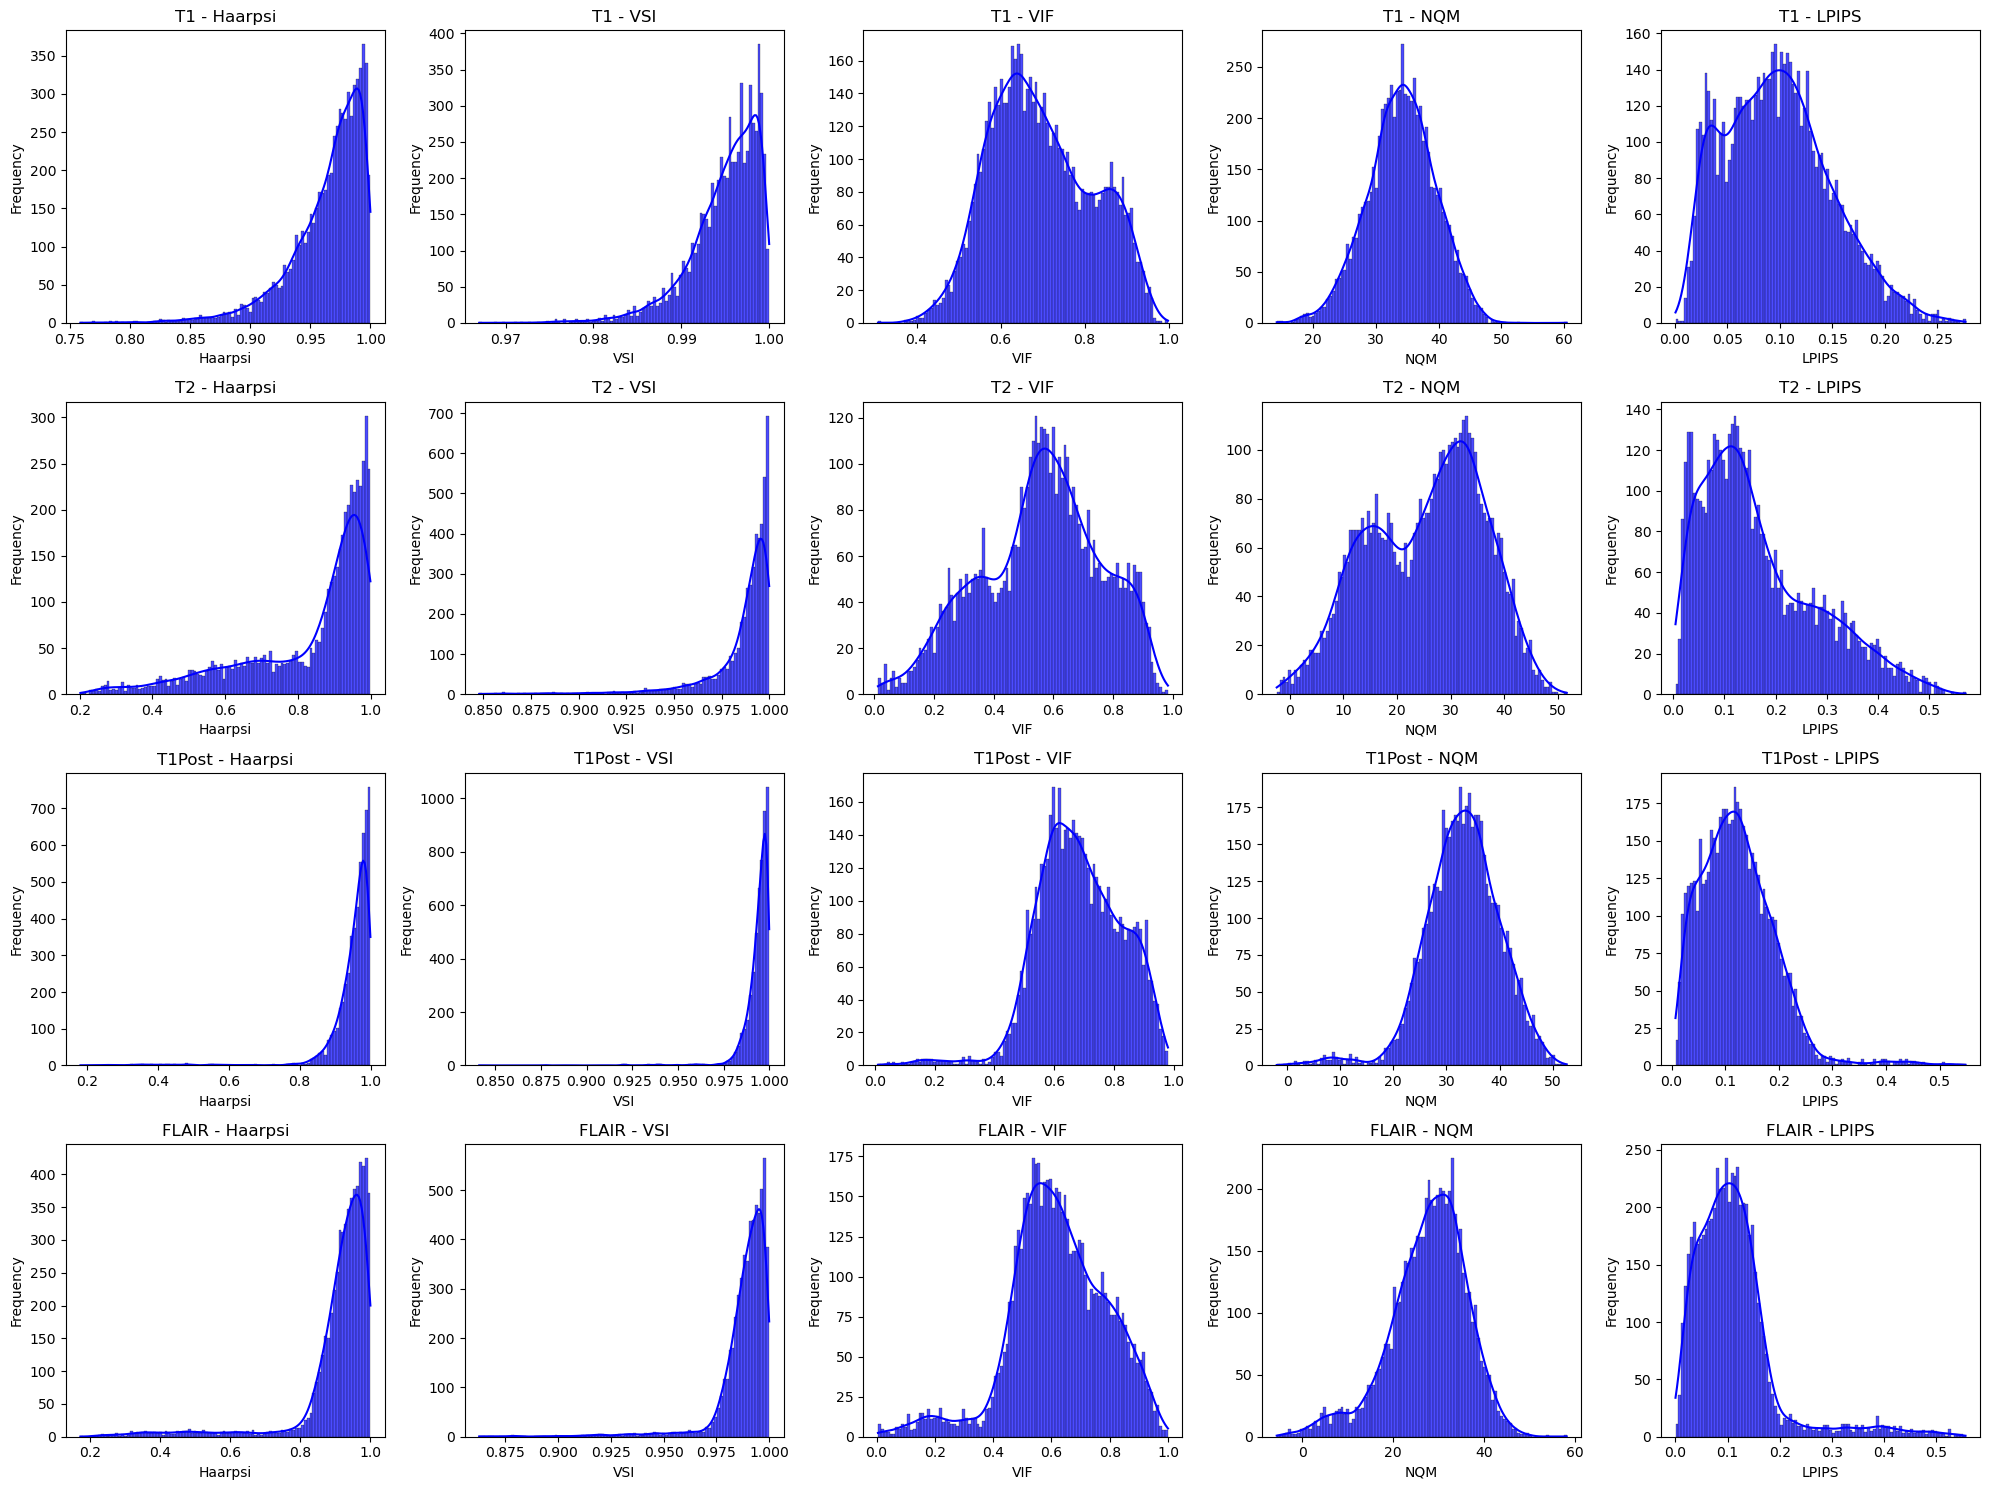

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

dfs = {
    'T1': t1_df,
    'T2': t2_df,
    'T1Post': t1post_df,
    'FLAIR': flair_df
}
columns = ['Haarpsi', 'VSI', 'VIF', 'NQM', 'LPIPS']

plt.figure(figsize=(20, 15))
plot_index = 1

for df_name, df in dfs.items():
    for column in columns:
        plt.subplot(len(dfs), len(columns), plot_index)
        sns.histplot(df[column], kde=True, bins=100, color='blue', alpha=0.7)
        plt.title(f'{df_name} - {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plot_index += 1

plt.tight_layout()
plt.show()

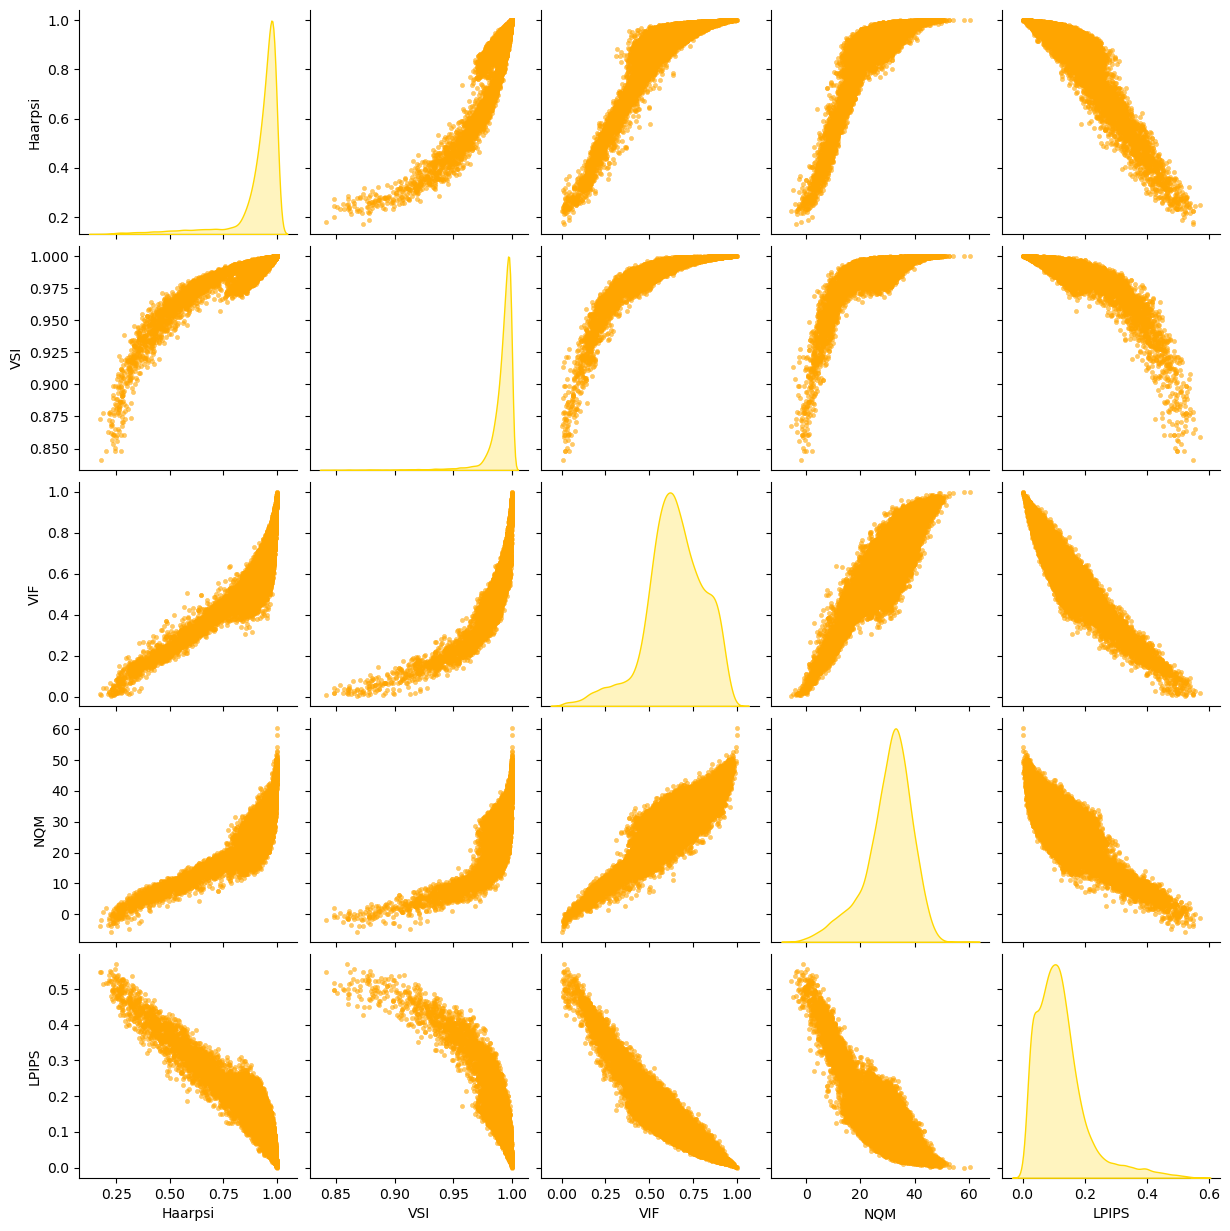

In [30]:
import seaborn as sns
# binned_df ,combined_df
sns.pairplot(combined_df[columns], diag_kind='kde',
             plot_kws={'alpha': 0.6, 's': 10, 'edgecolor': None, 'color': 'orange'},
             diag_kws={'color': 'gold'})

plt.show()

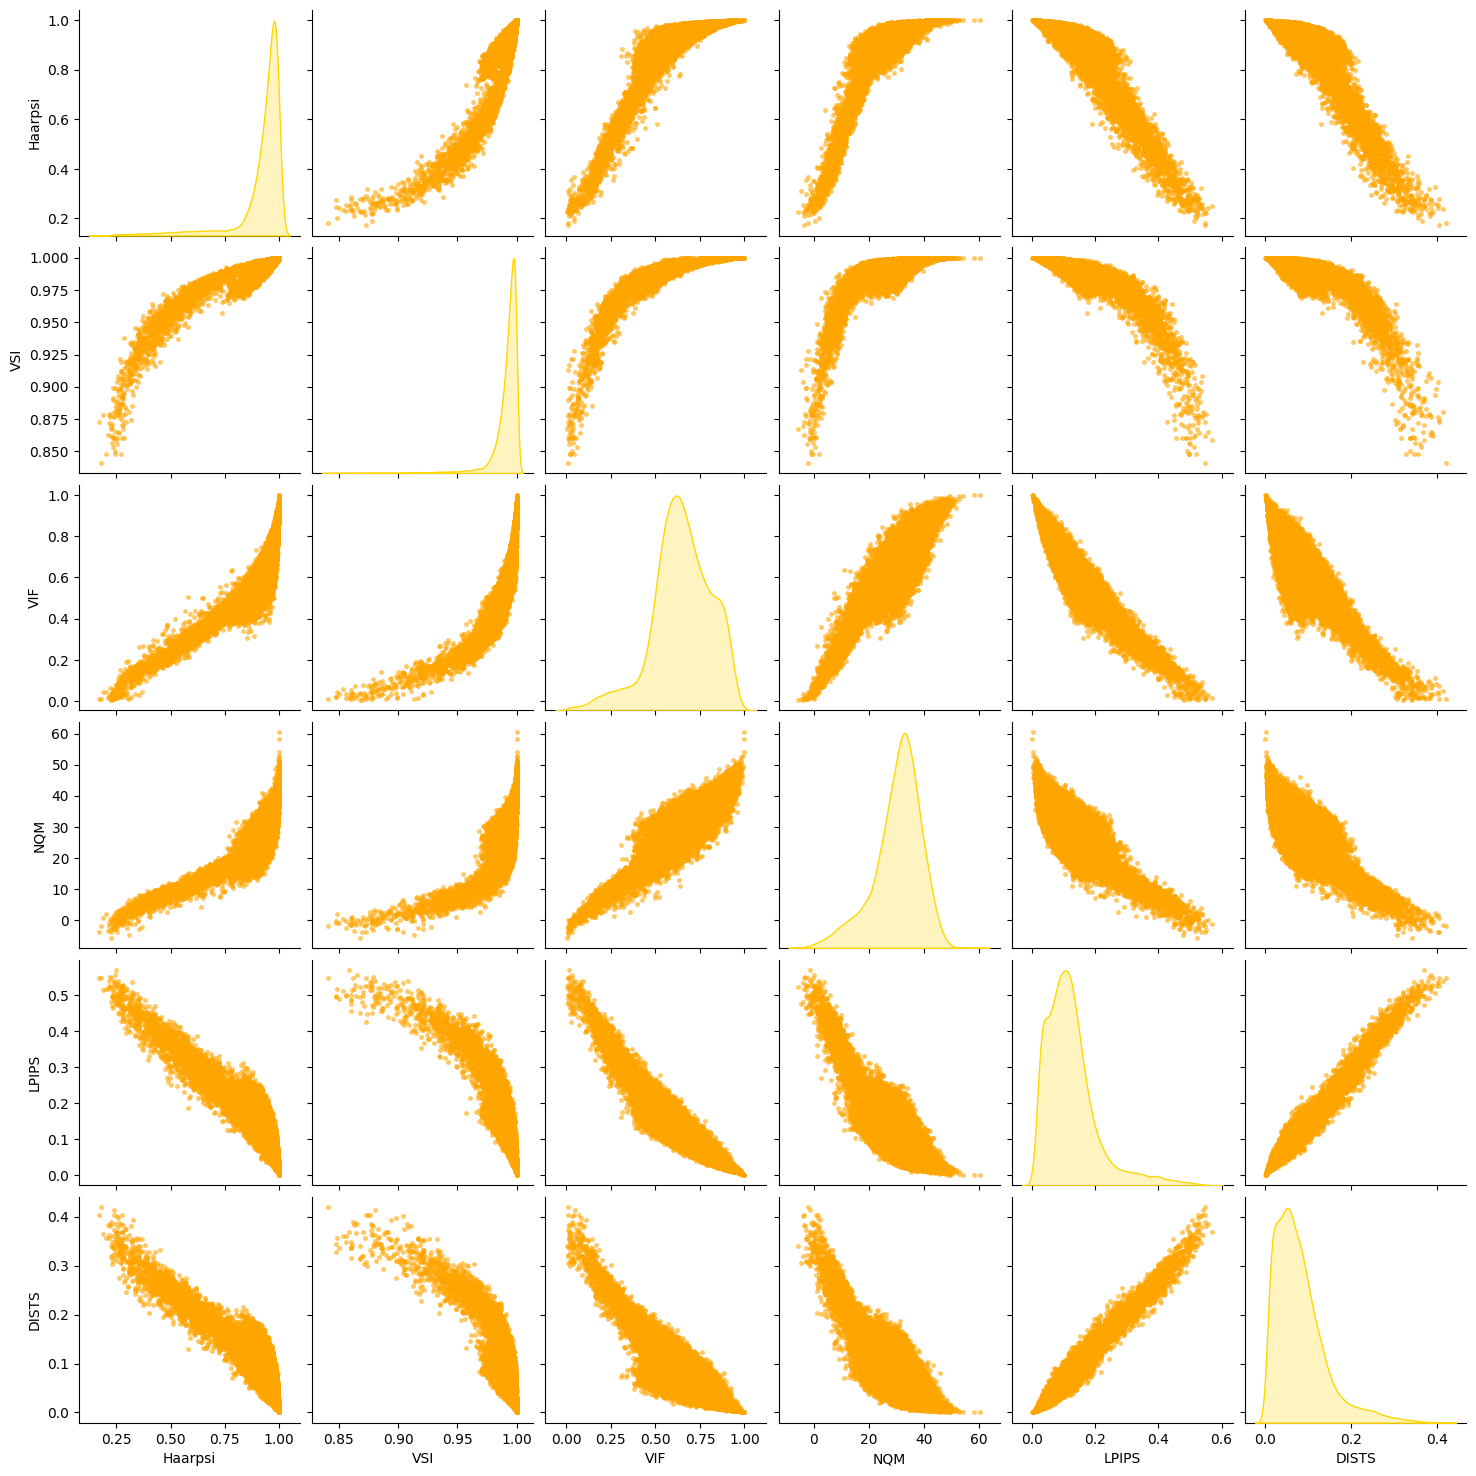

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

combined_df = pd.read_csv("fr-iqm_20250506.csv")
columns = ['Haarpsi', 'VSI', 'VIF', 'NQM', 'LPIPS', 'DISTS']
sns.pairplot(combined_df[columns], diag_kind='kde',
             plot_kws={'alpha': 0.6, 's': 10, 'edgecolor': None, 'color': 'orange'},
             diag_kws={'color': 'gold'})

plt.show()

Haarpsi, VIF, LPIPS